# Evaluation with Rare Pattern Boosting

Evaluate GAE anomaly detection with and without rare pattern boosting.


In [1]:
import torch
import numpy as np
import pickle
from pathlib import Path
from sklearn.metrics import roc_curve, confusion_matrix
import matplotlib.pyplot as plt

print("Libraries imported")


Libraries imported


## Configuration


In [2]:
DATA_DIR = "data"
MODEL_DIR = "models"
RARE_PATTERNS_DIR = "rare_patterns"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {device}")
print(f"Data: {DATA_DIR}/")
print(f"Model: {MODEL_DIR}/")
print(f"Rare patterns: {RARE_PATTERNS_DIR}/")


Device: cuda
Data: data/
Model: models/
Rare patterns: rare_patterns/


## Load Model and Test Data


In [3]:
from utils import GAE, load_model

# Load test graph
test_graph = torch.load(Path(DATA_DIR) / "test_graph.pt", weights_only=False)
test_graph = test_graph.to(device)

print(f"Test graph:")
print(f"  Nodes: {test_graph.num_nodes:,}")
print(f"  Edges: {test_graph.num_edges:,}")
print(f"  Features: {test_graph.num_node_features}")
print(f"  Attack nodes: {(test_graph.y == 1).sum().item()}")

# Load trained model
checkpoint = torch.load(Path(MODEL_DIR) / "gae_trained.pt", weights_only=False)
hyperparams = checkpoint['hyperparameters']

model = GAE(
    input_dim=test_graph.num_node_features,
    hidden_dim=hyperparams['hidden_dim'],
    latent_dim=hyperparams['latent_dim']
)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"Model loaded:")
print(f"  Hidden dim: {hyperparams['hidden_dim']}")
print(f"  Latent dim: {hyperparams['latent_dim']}")
print(f"  Training loss: {checkpoint['metrics']['final_loss']:.4f}")


Test graph:
  Nodes: 81,731
  Edges: 888,913
  Features: 299
  Attack nodes: 25
Model loaded:
  Hidden dim: 128
  Latent dim: 64
  Training loss: 0.7632


## Compute Anomaly Scores


In [4]:
print("Computing anomaly scores...")

with torch.no_grad():
    z = model.encode(test_graph.x, test_graph.edge_index)
    anomaly_scores = model.compute_anomaly_scores(z, test_graph.edge_index)

anomaly_scores_np = anomaly_scores.cpu().numpy()
y_true = test_graph.y.cpu().numpy()

print(f"Anomaly scores computed:")
print(f"  Min score: {anomaly_scores_np.min():.4f}")
print(f"  Max score: {anomaly_scores_np.max():.4f}")
print(f"  Mean score: {anomaly_scores_np.mean():.4f}")

normal_scores = anomaly_scores_np[y_true == 0]
attack_scores = anomaly_scores_np[y_true == 1]

print(f"\nScore distribution:")
print(f"  Normal: {normal_scores.mean():.4f} ± {normal_scores.std():.4f}")
print(f"  Attack: {attack_scores.mean():.4f} ± {attack_scores.std():.4f}")


Computing anomaly scores...
Anomaly scores computed:
  Min score: 0.0000
  Max score: 2.4889
  Mean score: 0.0930

Score distribution:
  Normal: 0.0929 ± 0.0354
  Attack: 0.4287 ± 0.2589


## Baseline nDCG Evaluation


In [5]:
def normalized_discounted_cumulative_gain(ranks, num_gt):
    """Calculate nDCG score"""
    dcg = sum([1.0 / np.log2(i + 1) for i in ranks])
    maxdcg = sum([1.0 / np.log2(i + 1) for i in range(1, num_gt + 1)])
    if maxdcg == 0:
        return 0.0
    return dcg / maxdcg

# Rank by anomaly scores
ranked_indices = np.argsort(anomaly_scores_np)[::-1]
ranked_labels = y_true[ranked_indices]
true_positive_positions = np.where(ranked_labels == 1)[0] + 1

num_attacks = (y_true == 1).sum()
baseline_ndcg = normalized_discounted_cumulative_gain(true_positive_positions, num_attacks)

print(f"Baseline nDCG (GAE only): {baseline_ndcg:.4f}")
print(f"Total attacks: {num_attacks}")
print(f"Best position: {true_positive_positions.min()}")
print(f"Worst position: {true_positive_positions.max()}")
print(f"Median position: {np.median(true_positive_positions):.0f}")


Baseline nDCG (GAE only): 0.5379
Total attacks: 25
Best position: 3
Worst position: 81699
Median position: 70


## Load Rare Patterns


In [6]:
rare_graph_path = Path(RARE_PATTERNS_DIR) / "rare_graph_test.pt"

if rare_graph_path.exists():
    rare_graph_test = torch.load(rare_graph_path, weights_only=False)
    rare_graph_test = rare_graph_test.to(device)
    
    print(f"Loaded rare pattern graph:")
    print(f"  Nodes: {rare_graph_test.num_nodes:,}")
    print(f"  Edges: {rare_graph_test.num_edges:,}")
else:
    print("No rare pattern graph found")
    rare_graph_test = None


Loaded rare pattern graph:
  Nodes: 81,731
  Edges: 9,056,962


## Test Score Boosting


In [7]:
from utils.rare_patterns import boost_anomaly_scores

if rare_graph_test is not None and rare_graph_test.num_edges > 0:
    print("Testing different α values...")
    
    alphas = [0.0, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
    # alphas = [2,3]
    results = {}
    
    for alpha in alphas:
        if alpha == 0.0:
            boosted_scores_np = anomaly_scores_np
            ndcg_new = baseline_ndcg
        else:
            boosted_scores = boost_anomaly_scores(
                torch.tensor(anomaly_scores_np, device=device),
                rare_graph_test,
                alpha=alpha,
                method='binary'
            )
            
            boosted_scores_np = boosted_scores.cpu().numpy()
            ranked_indices_new = np.argsort(boosted_scores_np)[::-1]
            ranked_labels_new = y_true[ranked_indices_new]
            positions_new = np.where(ranked_labels_new == 1)[0] + 1
            
            ndcg_new = normalized_discounted_cumulative_gain(positions_new, num_attacks)
        
        results[alpha] = {
            'ndcg': ndcg_new,
            'improvement': ndcg_new - baseline_ndcg
        }
        
        print(f"  α = {alpha:5.1f}: nDCG = {ndcg_new:.4f} (Δ = {results[alpha]['improvement']:+.4f})")
    
    best_alpha = max(results, key=lambda k: results[k]['ndcg'])
    best_ndcg = results[best_alpha]['ndcg']
    
    print(f"Best α = {best_alpha}: nDCG = {best_ndcg:.4f}")
    print(f"Improvement: {best_ndcg - baseline_ndcg:+.4f} ({(best_ndcg/baseline_ndcg-1)*100:+.1f}%)")
else:
    print("No rare patterns available for boosting")
    results = {}


Testing different α values...
  α =   0.0: nDCG = 0.5379 (Δ = +0.0000)
Scores boosted with α=0.1
   Nodes with rare patterns: 12,847
   Avg bonus: 0.1572
  α =   0.1: nDCG = 0.5552 (Δ = +0.0173)
Scores boosted with α=0.5
   Nodes with rare patterns: 12,847
   Avg bonus: 0.1572
  α =   0.5: nDCG = 0.5907 (Δ = +0.0529)
Scores boosted with α=1.0
   Nodes with rare patterns: 12,847
   Avg bonus: 0.1572
  α =   1.0: nDCG = 0.5900 (Δ = +0.0522)
Scores boosted with α=2.0
   Nodes with rare patterns: 12,847
   Avg bonus: 0.1572
  α =   2.0: nDCG = 0.6656 (Δ = +0.1277)
Scores boosted with α=5.0
   Nodes with rare patterns: 12,847
   Avg bonus: 0.1572
  α =   5.0: nDCG = 0.6634 (Δ = +0.1255)
Scores boosted with α=10.0
   Nodes with rare patterns: 12,847
   Avg bonus: 0.1572
  α =  10.0: nDCG = 0.6634 (Δ = +0.1255)
\nBest α = 2.0: nDCG = 0.6656
Improvement: +0.1277 (+23.7%)


## Plot Results


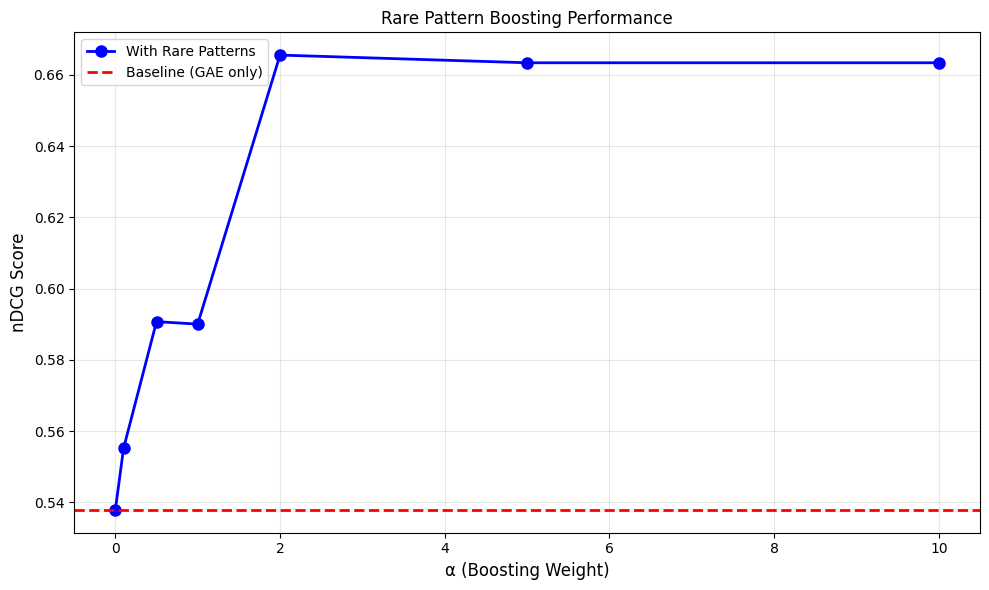

Plot displayed


In [8]:
if results:
    plt.figure(figsize=(10, 6))
    alphas_list = sorted(results.keys())
    ndcgs = [results[a]['ndcg'] for a in alphas_list]
    
    plt.plot(alphas_list, ndcgs, 'b-o', linewidth=2, markersize=8, label='With Rare Patterns')
    plt.axhline(y=baseline_ndcg, color='r', linestyle='--', linewidth=2, label='Baseline (GAE only)')
    
    plt.xlabel('α (Boosting Weight)', fontsize=12)
    plt.ylabel('nDCG Score', fontsize=12)
    plt.title('Rare Pattern Boosting Performance')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("Plot displayed")


## Summary


In [9]:
print("Evaluation complete:")
print(f"- Baseline nDCG: {baseline_ndcg:.4f}")

if results:
    print(f"- Best nDCG with boosting: {best_ndcg:.4f}")
    print(f"- Best α: {best_alpha}")
    print(f"- Improvement: {(best_ndcg/baseline_ndcg-1)*100:+.1f}%")
else:
    print("- No rare pattern boosting available")


Evaluation complete:
- Baseline nDCG: 0.5379
- Best nDCG with boosting: 0.6656
- Best α: 2.0
- Improvement: +23.7%
